# RFM Analysis

In [1]:
# importing libraries
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None)  # tüm sütunları gösterir
# pd.set_option('display.max_rows', None) # tüm satırları gösterir
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # numeric değerleri float virgülden sonra 4 hane gösterir

In [2]:
pip install xlrd==1.2.0 

     |████████████████████████████████| 103 kB 5.4 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install openpyxl


     |████████████████████████████████| 243 kB 5.2 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [4]:
# reading the data

df_ = pd.read_excel("../input/uci-online-retail-ii-data-set/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [6]:


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:

# descriptive statistics info
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [8]:
# empty value checking
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [9]:
# re-check 
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [10]:
# unique values count

df["StockCode"].nunique()

4070

In [11]:

df.groupby('StockCode').agg({'Quantity': "sum"})


,Quantity
StockCode,
10002,1037
10080,495
10120,193
10125,1296
10133,2775
...,...
gift_0001_20,20
gift_0001_30,37
gift_0001_40,3


In [12]:
# top 5 product after sorting
df.groupby('StockCode').agg({'Quantity': "sum"}).sort_values(by="Quantity", ascending=False).head(5)


,Quantity
StockCode,
22197,56450
84077,53847
85099B,47363
85123A,38830
84879,36221


In [13]:
# right now the returned good invoices still in dataframe but we have to discard them

df = df[~df["Invoice"].str.contains("C", na=False)]  

In [14]:
# new observation for RFM metrics calculation
df["TotalPrice"] = df["Price"] * df["Quantity"]

In [15]:
df.groupby("Invoice").agg({"TotalPrice": "sum"})

,TotalPrice
Invoice,
536365,139.1200
536366,22.2000
536367,278.7300
536368,70.0500
536369,17.8500
...,...
581586,339.2000
581587,267.4500
A563185,11062.0600


# RFM metrics calculation 
### Recency   = Shows how many days have passed since the last invoice
### Frequency = Count of how many times they buy
### Monetary  = monetary value

In [16]:

today_date = dt.datetime(2011, 12, 11) 

rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda total: total.sum()})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[rfm["Monetary"] > 0]

In [17]:
# normalise the data from 1 to 5 
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str) +
                    rfm['monetary_score'].astype(str)).astype(int)

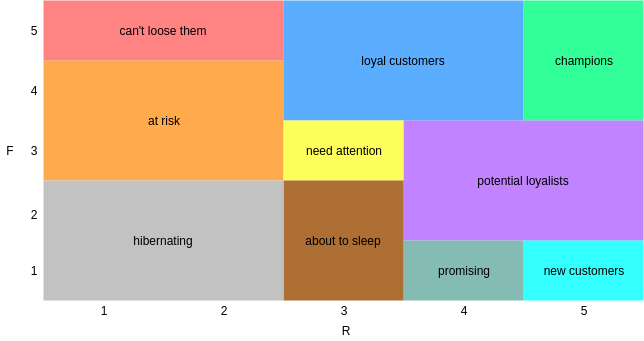   
this photo shows us  the classification of RM (Recency nd Monetary) metrics


In [18]:
# classification map
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [19]:

rfm['segment'] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)).replace(seg_map, regex=True)

In [20]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.0000,326,1,77183.6000,1,1,5,115,hibernating
12347.0000,3,7,4310.0000,5,5,5,555,champions
12348.0000,76,4,1797.2400,2,4,4,244,at_Risk
12349.0000,19,1,1757.5500,4,1,4,414,promising
12350.0000,311,1,334.4000,1,1,2,112,hibernating


In [21]:
rfm.groupby(["segment"]).agg({"RFM_SCORE": "mean"}).sort_values(by="RFM_SCORE", ascending=False)

,RFM_SCORE
segment,
champions,551.3949
new_customers,511.7143
potential_loyalists,468.8450
promising,411.5851
loyal_customers,409.0525
need_attention,332.8770
about_to_sleep,317.2926
cant_loose,236.8413
at_Risk,205.0287


# CLTV

In [22]:
 pip install lifetimes


     |████████████████████████████████| 584 kB 5.9 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [23]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

In [24]:
df = df_.copy()

In [25]:

df["Country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [27]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [28]:
df.dropna(inplace=True)

In [29]:
df = df[~df["Invoice"].str.contains("C", na=False)]  

In [30]:


df["TotalPrice"] = df["Quantity"] * df["Price"]


In [31]:
today_date = dt.datetime(2011, 12, 11)

In [32]:
# the difference from FRM to CLTV is we also checking the custom life value with first invoice to last invoice)
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


In [33]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']


In [34]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,77183.6000
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1797.2400
12349.0000,0,19,1,1757.5500
12350.0000,0,311,1,334.4000


In [35]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [36]:
cltv_df = cltv_df[cltv_df["monetary"] > 0]

In [37]:
# Expression of recency and T for BGNBD in weekly terms
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [38]:
# frequency must be bigger then 1 
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

#### Establishment of BG-NBD Model

In [39]:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

#### Establishment of GAMMA- GAMMA Model

In [40]:

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])


<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.72>

#### Calculation of CLTV with BG-NBD and GG model.

In [41]:

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # for 6 months
                                   freq="W",  
                                   discount_rate=0.01)


In [42]:
cltv.head()


Customer ID
12347.0000   2201.1330
12348.0000   1066.3371
12352.0000   1437.1981
12356.0000   2110.4305
12358.0000   1900.3552
Name: clv, dtype: float64

In [43]:

cltv = cltv.reset_index()
cltv.columns = ["Customer ID", "clv"]
cltv.sort_values(by="clv", ascending=False).head(50)
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [44]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,clv
1970,16446.0000,29.1429,29.4286,2,84236.2500,222174.6731
1122,14646.0000,50.4286,50.7143,74,3786.5678,114427.9995
2761,18102.0000,52.2857,52.5714,60,4327.6217,103726.3519
2458,17450.0000,51.2857,52.5714,46,4229.3650,78294.5326
843,14096.0000,13.8571,14.5714,17,3833.2229,68021.8367
36,12415.0000,44.7143,48.2857,21,5948.3110,56094.2473
1257,14911.0000,53.1429,53.4286,201,715.5476,55268.5391
874,14156.0000,51.5714,53.1429,55,2134.1751,46363.9816
1754,16000.0000,0.0000,0.4286,3,4131.2333,43009.3545
2487,17511.0000,52.8571,53.4286,31,2937.4961,37093.8375


In [45]:
# Standardization of CLTV
scaler = MinMaxScaler(feature_range=(0, 1)) # verileri okunabilir hale getirme amaçlı
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])


In [46]:
# sorting:
cltv_final.sort_values(by="scaled_clv", ascending=False).head()



,Customer ID,recency,T,frequency,monetary,clv,scaled_clv
1970,16446.0000,29.1429,29.4286,2,84236.2500,222174.6731,1.0000
1122,14646.0000,50.4286,50.7143,74,3786.5678,114427.9995,0.5150
2761,18102.0000,52.2857,52.5714,60,4327.6217,103726.3519,0.4669
2458,17450.0000,51.2857,52.5714,46,4229.3650,78294.5326,0.3524
843,14096.0000,13.8571,14.5714,17,3833.2229,68021.8367,0.3062


In [47]:
cltv_final_copy = cltv_final.copy()

Comment: It is predicted that the estimated profit that customer "18102" will get at the end of 6 months will be "85,651" unit

In [48]:
###### CLTV for 1 Months #########

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  
                                   freq="W",  
                                   discount_rate=0.01)

In [49]:
cltv.head()

Customer ID
12347.0000   382.9171
12348.0000   185.6408
12352.0000   250.7175
12356.0000   367.9822
12358.0000   335.4972
Name: clv, dtype: float64

In [50]:
cltv = cltv.reset_index()
cltv.columns = ["Customer ID", "clv"]
cltv.sort_values(by="clv", ascending=False).head(50)
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,clv
1970,16446.0000,29.1429,29.4286,2,84236.2500,39024.7524
1122,14646.0000,50.4286,50.7143,74,3786.5678,19899.6045
2761,18102.0000,52.2857,52.5714,60,4327.6217,18030.8899
2458,17450.0000,51.2857,52.5714,46,4229.3650,13610.5810
843,14096.0000,13.8571,14.5714,17,3833.2229,12054.9103
36,12415.0000,44.7143,48.2857,21,5948.3110,9763.7498
1257,14911.0000,53.1429,53.4286,201,715.5476,9604.5806
874,14156.0000,51.5714,53.1429,55,2134.1751,8058.5301
1754,16000.0000,0.0000,0.4286,3,4131.2333,7842.8548
2487,17511.0000,52.8571,53.4286,31,2937.4961,6447.5392


In [51]:

# Standardization of CLTV
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])


In [52]:
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,clv,scaled_clv
1970,16446.0000,29.1429,29.4286,2,84236.2500,39024.7524,1.0000
1122,14646.0000,50.4286,50.7143,74,3786.5678,19899.6045,0.5099
2761,18102.0000,52.2857,52.5714,60,4327.6217,18030.8899,0.4620
2458,17450.0000,51.2857,52.5714,46,4229.3650,13610.5810,0.3488
843,14096.0000,13.8571,14.5714,17,3833.2229,12054.9103,0.3089
36,12415.0000,44.7143,48.2857,21,5948.3110,9763.7498,0.2502
1257,14911.0000,53.1429,53.4286,201,715.5476,9604.5806,0.2461
874,14156.0000,51.5714,53.1429,55,2134.1751,8058.5301,0.2065
1754,16000.0000,0.0000,0.4286,3,4131.2333,7842.8548,0.2010
2487,17511.0000,52.8571,53.4286,31,2937.4961,6447.5392,0.1652


In [53]:
###### CLTV for 12 Months #########

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12,  
                                   freq="W", 
                                   discount_rate=0.01)

cltv.head()

cltv = cltv.reset_index()
cltv.columns = ["Customer ID", "clv"]
cltv.sort_values(by="clv", ascending=False).head(50)
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

cltv_final.sort_values(by="clv", ascending=False).head(10)

# Standardization of CLTV
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

# sorting:
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,clv,scaled_clv
1970,16446.0000,29.1429,29.4286,2,84236.2500,420946.6328,1.0000
1122,14646.0000,50.4286,50.7143,74,3786.5678,218426.5573,0.5189
2761,18102.0000,52.2857,52.5714,60,4327.6217,198066.5526,0.4705
2458,17450.0000,51.2857,52.5714,46,4229.3650,149499.4022,0.3552
843,14096.0000,13.8571,14.5714,17,3833.2229,128156.3293,0.3044
36,12415.0000,44.7143,48.2857,21,5948.3110,106999.5344,0.2542
1257,14911.0000,53.1429,53.4286,201,715.5476,105561.1399,0.2508
874,14156.0000,51.5714,53.1429,55,2134.1751,88541.2801,0.2103
1754,16000.0000,0.0000,0.4286,3,4131.2333,79875.6297,0.1898
2487,17511.0000,52.8571,53.4286,31,2937.4961,70835.7751,0.1683
